In [15]:
import sys
print(sys.executable)
print(sys.version)



C:\Anaconda3\python.exe
3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]


In [16]:
import sys
!"{sys.executable}" -m pip install torchsde


In [17]:
import torch
import torchsde

print("torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("torchsde imported OK")


torch: 2.9.0+cpu
CUDA available: False
torchsde imported OK


In [18]:
import datetime as dt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import argparse
import logging
import os
import time
import random
from collections import namedtuple
from typing import Optional, Union
import torch
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn, optim, distributions
import torch.backends.cudnn as cudnn
import tqdm
from scipy.stats import levy_stable
import torchsde
import seaborn as sns

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(4)


In [19]:
# === Config for your exchange-rate dataset ===
DATA_PATH = r"Exchange rate data.xlsx"   # <-- make sure this matches your file path
TARGET_COLUMN = "Nigeria"                  # or "Nigeria", etc.
ASSET_NAME = f"{TARGET_COLUMN} exchange rate"

# === Load data ===
data = pd.read_excel(DATA_PATH)

# Make sure the date column is called 'Date'
# (change 'Date' if your Excel sheet uses a different header)
date_col = "Date"

# Keep only the date + target series and rename to match template
data = data[[date_col, TARGET_COLUMN]].copy()
data.columns = ["date", "close"]

# Convert to numeric (in case the Excel column has strings)
data["close"] = pd.to_numeric(data["close"], errors="coerce")

# Drop rows where 'close' is missing or not numeric
data = data.dropna(subset=["close"]).reset_index(drop=True)

# For compatibility with the original code, create fake open/high/low/volume
data["open"] = data["close"]
data["high"] = data["close"]
data["low"]  = data["close"]
data["volume"] = 0.0

# Ensure sorted by time
data["date"] = pd.to_datetime(data["date"], errors="coerce")
data = data.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

print("✅ Data loaded successfully!")
print(data.info())
data.head()



✅ Data loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4331 entries, 0 to 4330
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4331 non-null   datetime64[ns]
 1   close   4331 non-null   float64       
 2   open    4331 non-null   float64       
 3   high    4331 non-null   float64       
 4   low     4331 non-null   float64       
 5   volume  4331 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 203.1 KB
None


,date,close,open,high,low,volume
0,2011-01-03,152.0,152.0,152.0,152.0,0.0
1,2011-01-04,152.3,152.3,152.3,152.3,0.0
2,2011-01-05,152.0,152.0,152.0,152.0,0.0
3,2011-01-06,152.0,152.0,152.0,152.0,0.0
4,2011-01-07,152.2,152.2,152.2,152.2,0.0


In [20]:
# === Data Cleaning and Splitting ===

# Create new dataframe with only relevant columns
stk_data = pd.DataFrame(columns=["Date", "Open", "High", "Low", "Close"])
stk_data["Date"] = data["date"]
stk_data["Open"] = data["open"]
stk_data["High"] = data["high"]
stk_data["Low"]  = data["low"]
stk_data["Close"] = data["close"]

stk_data.head()


,Date,Open,High,Low,Close
0,2011-01-03,152.0,152.0,152.0,152.0
1,2011-01-04,152.3,152.3,152.3,152.3
2,2011-01-05,152.0,152.0,152.0,152.0
3,2011-01-06,152.0,152.0,152.0,152.0
4,2011-01-07,152.2,152.2,152.2,152.2


In [21]:
# Define the training set
percent_training: float = 0.80
num_training_samples = int(np.ceil(percent_training * len(stk_data)))  # number of training samples

# Use Close column (index 4) exactly like the original
training_set = stk_data.iloc[:num_training_samples, 4:5].values

# Define the test data
num_testing_samples: int = len(stk_data) - num_training_samples
testing_set = stk_data.iloc[-num_testing_samples:, 4:5].values

print("Training set shape:", training_set.shape, "\nTesting set shape:", testing_set.shape)


Training set shape: (3465, 1) 
Testing set shape: (866, 1)


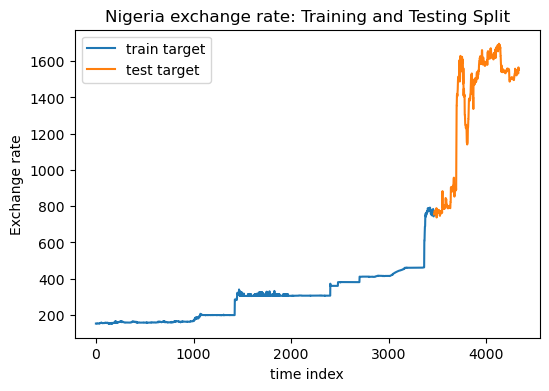

In [22]:
# Show train/test split on the series
plt.figure(figsize=(6, 4))
plt.plot(np.arange(training_set.shape[0]), training_set, label="train target")
plt.plot(
    np.arange(training_set.shape[0], training_set.shape[0] + testing_set.shape[0]),
    testing_set,
    label="test target"
)
plt.title(f"{ASSET_NAME}: Training and Testing Split")
plt.xlabel("time index")
plt.ylabel("Exchange rate")
plt.legend(loc="best")
plt.show()


In [23]:
# === Standardise the data (same scaler logic as template) ===
scaler = StandardScaler()
training_set_scaled = scaler.fit_transform(training_set)   # 2D (num_train, 1)
testing_set_scaled  = scaler.transform(testing_set)        # 2D (num_test, 1)

# ---- Build train DataFrame: [Date, scaled_close] ----
train_scaled_flat = training_set_scaled.flatten()
train_scaled_df = pd.DataFrame({"closescale": train_scaled_flat})

train_dates = stk_data.loc[0:len(train_scaled_df) - 1, "Date"].to_frame()
training_set_scaled3 = pd.concat([train_dates, train_scaled_df], axis=1)
training_set_scaled3.head()


,Date,closescale
0,2011-01-03,-1.081941
1,2011-01-04,-1.079651
2,2011-01-05,-1.081941
3,2011-01-06,-1.081941
4,2011-01-07,-1.080414


In [24]:
# ---- Build test DataFrame: [Date, scaled_close] ----
test_scaled_flat = testing_set_scaled.flatten()
test_scaled_df = pd.DataFrame({"closescale": test_scaled_flat})

test_dates = stk_data.loc[len(training_set_scaled3):, "Date"].to_frame()
# ensure it's a clean DataFrame with 'Date' column
test_dates = pd.DataFrame({"Date": test_dates.values.flatten()})

testing_set_scaled3 = pd.concat([test_dates, test_scaled_df], axis=1)
testing_set_scaled3.head()


,Date,closescale
0,2023-08-24,3.514564
1,2023-08-24,3.514564
2,2023-08-25,3.641496
3,2023-08-25,3.641496
4,2023-08-28,3.664852


In [25]:
# Phase-space reconstruction:
# df: DataFrame with columns [Date, value]
# tau: delay
# d: embedding dimension
# T: prediction horizon (steps ahead)
def PhaSpaRecon(df, tau, d, T):
    data = np.array(df)[:, 1]   # scaled values
    date = np.array(df)[:, 0]   # dates
    lens = len(data)
    if (lens - T - (d - 1) * tau) < 1:
        print("error: delay time or the embedding dimension is too large")
    else:
        Xn1 = np.zeros((d, lens - (d - 1) * tau - 1))
        for i in range(d):
            Xn1[i, :] = data[i * tau : i * tau + lens - (d - 1) * tau - 1]

        Yn1 = data[(T + (d - 1) * tau) : T + (d - 1) * tau + lens - (d - 1) * tau - 1]
        Yn1_date = date[(T + (d - 1) * tau) : T + (d - 1) * tau + lens - (d - 1) * tau - 1]

        Yn = Yn1.reshape((len(Yn1), 1))
        Yn_date = Yn1_date.reshape((len(Yn1_date), 1))
        Yn = pd.DataFrame(Yn)
        Yn_date = pd.DataFrame(Yn_date)
        Y = pd.concat([Yn_date, Yn], axis=1)

        Xn = Xn1.T
        Xn = pd.DataFrame(Xn)
        X = pd.concat([Xn, Yn], axis=1)
    return Xn, Yn, Y, X


In [26]:
tau = 1
d = 16       # or your estimated embedding dimension (e.g. 30)
T = 1        # 1-step ahead

# Train reconstruction
Xn, Yn, Y, X = PhaSpaRecon(training_set_scaled3, tau=tau, d=d, T=T)
train = X.values
x_train1 = train[:, 0:d]
y_train1 = train[:, d]

# Test reconstruction
X1n, Y1n, Y1, X1 = PhaSpaRecon(testing_set_scaled3, tau=tau, d=d, T=T)
test = X1.values
x_test1 = test[:, 0:d]
y_test1 = test[:, d]

print(
    "x_train1 shape:", x_train1.shape,
    "\nx_test1 shape:", x_test1.shape,
    "\ny_train1 shape:", y_train1.shape,
    "\ny_test1 shape:", y_test1.shape
)


x_train1 shape: (3449, 16) 
x_test1 shape: (850, 16) 
y_train1 shape: (3449,) 
y_test1 shape: (850,)


In [27]:
# Simple time index for plotting later (optional)
ts_      = np.arange(0, y_train1.shape[0])
ts_ext_  = np.arange(y_train1.shape[0], y_train1.shape[0] + y_test1.shape[0])
ts_full_ = np.arange(0, y_train1.shape[0] + y_test1.shape[0])


x_train shape: (3449, 16)
y_train shape: (3449,)
x_test shape: (850, 16)
y_test shape: (850,)
Using device: cpu
SDENet1(
  (downsampling_layers): Linear(in_features=16, out_features=16, bias=True)
  (drift): Drift1(
    (fc): Linear(in_features=16, out_features=16, bias=True)
    (relu): ReLU(inplace=True)
  )
  (diffusion): Diffusion1(
    (fc): Linear(in_features=16, out_features=16, bias=True)
    (relu): ReLU(inplace=True)
  )
  (readout): Linear(in_features=16, out_features=1, bias=True)
)
Epoch   1/100  Train MSE: 0.558900  Test MSE: 32.055292
Epoch  10/100  Train MSE: 0.013060  Test MSE: 0.805488
Epoch  20/100  Train MSE: 0.008550  Test MSE: 0.243595
Epoch  30/100  Train MSE: 0.342091  Test MSE: 0.266973
Epoch  40/100  Train MSE: 0.004045  Test MSE: 0.251944
Epoch  50/100  Train MSE: 0.007012  Test MSE: 0.090738
Epoch  60/100  Train MSE: 0.012185  Test MSE: 0.093962
Epoch  70/100  Train MSE: 0.002355  Test MSE: 0.072997
Epoch  80/100  Train MSE: 0.002187  Test MSE: 0.145044
Epoc

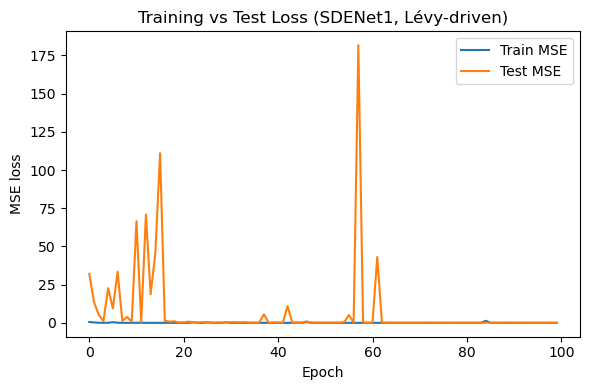

Test RMSE: 32.673844
Test MAE : 19.980814
Test MAPE: 1.558%


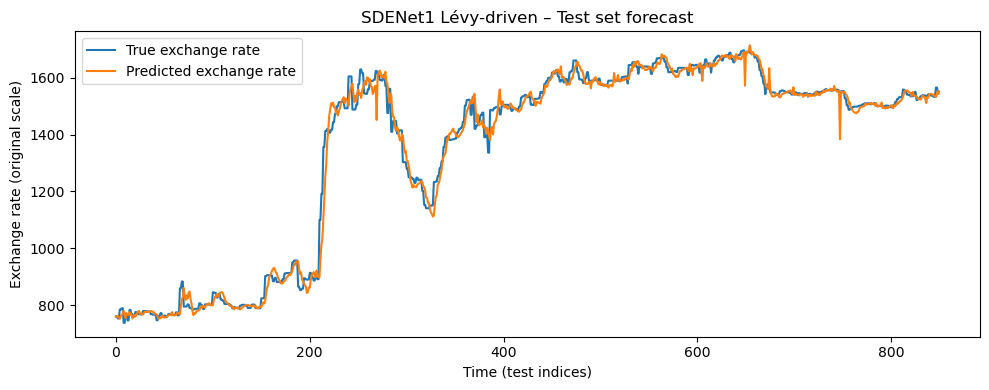

In [28]:
# ==============================
# 1. Bind reconstructed data
# ==============================
x_train = x_train1
y_train = y_train1
x_test  = x_test1
y_test  = y_test1

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# ==============================
# 2. Ensure numeric (but now no NaNs ideally)
# ==============================
def ensure_numeric(a):
    if isinstance(a, pd.DataFrame):
        a = a.values
    a = np.asarray(a, dtype=np.float32)
    if np.isnan(a).any():
        print("⚠️ Still found NaNs – consider checking the data!")
        a = np.nan_to_num(a)
    return a

x_train = ensure_numeric(x_train)
x_test  = ensure_numeric(x_test)
y_train = ensure_numeric(y_train)
y_test  = ensure_numeric(y_test)

# ==============================
# 3. Tensors & loaders
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

x_test_t = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_dataset = TensorDataset(x_train_t, y_train_t)
test_dataset  = TensorDataset(x_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ==============================
# 4. SDENet1 – closer to original
# ==============================
sequence_length = x_train.shape[1]   # should be 23
alpha, beta = 1.2, 0.0              # as in the original notebook

class Drift1(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, t, x):
        return self.relu(self.fc(x))


class Diffusion1(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, t, x):
        return self.relu(self.fc(x))


class SDENet1(nn.Module):
    """
    X_{k+1} = X_k + f(X_k)*dt + sigma*g(X_k)*dt^{1/alpha} * ΔL_k
    where ΔL_k are α-stable increments.
    """
    def __init__(self, dim, layer_depth=6, alpha=1.2, beta=0.0, sigma=0.5):
        super().__init__()
        self.dim = dim
        self.layer_depth = layer_depth
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma

        self.downsampling_layers = nn.Linear(dim, dim)
        self.drift = Drift1(dim)
        self.diffusion = Diffusion1(dim)

        self.deltat = 1.0 / layer_depth
        self.readout = nn.Linear(dim, 1)

    def _levy_noise(self, batch_size):
        """
        Sample α-stable noise: shape (batch_size, dim)
        scale is set to 0.1 as in the original code.
        """
        noise_np = levy_stable.rvs(
            self.alpha,
            self.beta,
            size=(batch_size, self.dim),
            scale=0.1
        ).astype(np.float32)
        return torch.from_numpy(noise_np)

    def forward(self, x, training_diffusion=False):
        """
        x: (batch_size, dim)
        training_diffusion flag kept for compatibility but not used here.
        """
        batch_size = x.shape[0]
        out = self.downsampling_layers(x)

        # diffusion term is held constant across steps, as in original
        t = 0.0
        diffusion_term = self.sigma * self.diffusion(t, out)

        for i in range(self.layer_depth):
            t = float(i) / self.layer_depth
            drift = self.drift(t, out)
            noise = self._levy_noise(batch_size).to(out.device)

            out = out + drift * self.deltat \
                  + diffusion_term * (self.deltat ** (1.0 / self.alpha)) * noise

        return self.readout(out)


model = SDENet1(dim=sequence_length, layer_depth=6, alpha=alpha, beta=beta, sigma=0.5).to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # smaller LR for stability

# ==============================
# 5. Training loop
# ==============================
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Evaluate
    model.eval()
    test_running_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            test_running_loss += loss.item() * xb.size(0)

    epoch_test_loss = test_running_loss / len(test_dataset)
    test_losses.append(epoch_test_loss)

    if epoch % 10 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:3d}/{num_epochs}  "
            f"Train MSE: {epoch_train_loss:.6f}  "
            f"Test MSE: {epoch_test_loss:.6f}"
        )

# ==============================
# 6. Loss curves
# ==============================
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train MSE")
plt.plot(test_losses, label="Test MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training vs Test Loss (SDENet1, Lévy-driven)")
plt.legend()
plt.tight_layout()
plt.show()

# ==============================
# 7. Predictions (scaled space)
# ==============================
model.eval()
with torch.no_grad():
    y_train_pred_scaled = model(x_train_t).cpu().numpy().reshape(-1, 1)
    y_test_pred_scaled  = model(x_test_t).cpu().numpy().reshape(-1, 1)

y_train_scaled = y_train.reshape(-1, 1)
y_test_scaled  = y_test.reshape(-1, 1)

# ==============================
# 8. Back to original scale
# ==============================
y_train_real = scaler.inverse_transform(y_train_scaled)
y_test_real  = scaler.inverse_transform(y_test_scaled)

y_train_pred_real = scaler.inverse_transform(y_train_pred_scaled)
y_test_pred_real  = scaler.inverse_transform(y_test_pred_scaled)

# ==============================
# 9. Metrics
# ==============================
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_test = math.sqrt(mean_squared_error(y_test_real, y_test_pred_real))
mae_test  = mean_absolute_error(y_test_real, y_test_pred_real)
mape_test = np.mean(np.abs((y_test_real - y_test_pred_real) / y_test_real)) * 100

print(f"Test RMSE: {rmse_test:.6f}")
print(f"Test MAE : {mae_test:.6f}")
print(f"Test MAPE: {mape_test:.3f}%")

# ==============================
# 10. Plot true vs predicted (test)
# ==============================
plt.figure(figsize=(10, 4))
plt.plot(y_test_real, label="True exchange rate")
plt.plot(y_test_pred_real, label="Predicted exchange rate")
plt.xlabel("Time (test indices)")
plt.ylabel("Exchange rate (original scale)")
plt.title("SDENet1 Lévy-driven – Test set forecast")
plt.legend()
plt.tight_layout()
plt.show()


In [30]:


import numpy as np
import pandas as pd
import math

from sklearn.metrics import mean_squared_error, mean_absolute_error

!pip install arch

# ------------------------------
# 0) Safety checks: required variables
# ------------------------------
required_vars = ["x_train1", "y_train1", "x_test1", "y_test1", "scaler"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(f"Missing variables in notebook: {missing}. Make sure preprocessing/splitting cells ran.")

# Bind split arrays (as in your file)
x_train = x_train1
y_train = y_train1
x_test  = x_test1
y_test  = y_test1

# Make sure numeric
def ensure_numeric(a):
    if isinstance(a, pd.DataFrame):
        a = a.values
    a = np.asarray(a, dtype=np.float32)
    if np.isnan(a).any():
        a = np.nan_to_num(a)
    return a

x_train = ensure_numeric(x_train)
x_test  = ensure_numeric(x_test)
y_train = ensure_numeric(y_train).reshape(-1, 1)
y_test  = ensure_numeric(y_test).reshape(-1, 1)

# Convert to real/original scale (THIS is what we compare in Table 3)
y_train_real = scaler.inverse_transform(y_train)
y_test_real  = scaler.inverse_transform(y_test)

# Metrics helper
def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1, 1)
    y_pred = np.asarray(y_pred).reshape(-1, 1)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

results = []

# Helper to add a row
def add_row(model_name, y_pred_real, y_true_real=y_test_real):
    mse, rmse, mae = compute_metrics(y_true_real, y_pred_real)
    results.append({
        "Data": "Nigeria",
        "Model": model_name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae
    })
    print(f"{model_name:12s} | MSE={mse:.6f} RMSE={rmse:.6f} MAE={mae:.6f}")

# ============================================================
# 1) ARIMA baseline (fits on TRAIN LEVELS, forecasts TEST length)
# ============================================================
try:
    from statsmodels.tsa.arima.model import ARIMA

    ytr = y_train_real.flatten()
    yte = y_test_real.flatten()

    # Simple fixed order (paper baseline). You can change this.
    order = (1, 1, 1)

    arima_model = ARIMA(ytr, order=order).fit()
    arima_forecast = arima_model.forecast(steps=len(yte)).reshape(-1, 1)

    add_row(f"ARIMA{order}", arima_forecast, y_test_real)

except Exception as e:
    print("\n[ARIMA] Could not run ARIMA. If statsmodels isn't installed, run:")
    print("  pip install statsmodels")
    print("Error:", e)

# ============================================================
# 2) GARCH(1,1) baseline (models DIFFS, then reconstructs levels)
# ============================================================
try:
    from arch import arch_model

    ytr = y_train_real.flatten()
    yte = y_test_real.flatten()

    # Use first-differences to make it more standard for GARCH
    r_train = np.diff(ytr)  # length = len(train)-1

    # Mean + GARCH variance
    am = arch_model(r_train, mean="Constant", vol="Garch", p=1, q=1)
    res = am.fit(disp="off")

    # Forecast mean differences across the test horizon
    fc = res.forecast(horizon=len(yte))
    r_hat = fc.mean.values[-1, :]  # shape (len(test),)

    # Reconstruct level forecasts from last training level
    y0 = ytr[-1]
    y_hat = y0 + np.cumsum(r_hat)

    # Align ground-truth length (same as y_hat)
    y_test_real_aligned = yte[:len(y_hat)].reshape(-1, 1)
    y_hat = y_hat.reshape(-1, 1)

    add_row("GARCH(1,1)", y_hat, y_test_real_aligned)

except Exception as e:
    print("\n[GARCH] Could not run GARCH. If arch isn't installed, run:")
    print("  pip install arch")
    print("Error:", e)

# ============================================================
# 3) ANN baseline (simple MLPRegressor on WINDOWED INPUTS)
#    Trains/predicts in SCALED space then inverse-transform target.
# ============================================================
try:
    from sklearn.neural_network import MLPRegressor

    # ANN learns: x_train (windows) -> y_train (next value)
    ann = MLPRegressor(
        hidden_layer_sizes=(64, 64),
        activation="relu",
        solver="adam",
        max_iter=500,
        random_state=42
    )
    ann.fit(x_train, y_train.flatten())
    ann_pred_scaled = ann.predict(x_test).reshape(-1, 1)
    ann_pred_real = scaler.inverse_transform(ann_pred_scaled)

    add_row("ANN", ann_pred_real, y_test_real)

except Exception as e:
    print("\n[ANN] Could not run ANN baseline.")
    print("Error:", e)

# ============================================================
# 4) LSTM baseline (PyTorch) on WINDOWED INPUTS
#    Input: (N, seq_len, 1) where seq_len = x_train.shape[1]
#    Target: next value y (scaled), then inverse-transform predictions.
# ============================================================
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import TensorDataset, DataLoader

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    seq_len = x_train.shape[1]

    # reshape windows into sequences
    Xtr = torch.tensor(x_train, dtype=torch.float32).unsqueeze(-1).to(device)  # (N, seq_len, 1)
    ytr = torch.tensor(y_train, dtype=torch.float32).to(device)                # (N, 1)

    Xte = torch.tensor(x_test, dtype=torch.float32).unsqueeze(-1).to(device)   # (M, seq_len, 1)
    yte = torch.tensor(y_test, dtype=torch.float32).to(device)                 # (M, 1)

    train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)

    class LSTMRegressor(nn.Module):
        def __init__(self, hidden=64, num_layers=1):
            super().__init__()
            self.lstm = nn.LSTM(input_size=1, hidden_size=hidden, num_layers=num_layers, batch_first=True)
            self.fc = nn.Linear(hidden, 1)

        def forward(self, x):
            out, _ = self.lstm(x)        # out: (N, seq_len, hidden)
            last = out[:, -1, :]         # last step
            return self.fc(last)         # (N, 1)

    lstm_model = LSTMRegressor(hidden=64, num_layers=1).to(device)
    crit = nn.MSELoss()
    opt = optim.Adam(lstm_model.parameters(), lr=1e-3)

    # quick baseline training (keep it modest so it runs)
    epochs = 30
    for ep in range(1, epochs + 1):
        lstm_model.train()
        total = 0.0
        for xb, yb in train_loader:
            opt.zero_grad()
            pred = lstm_model(xb)
            loss = crit(pred, yb)
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)

        if ep % 10 == 0 or ep == 1:
            print(f"LSTM epoch {ep:2d}/{epochs} | train MSE={total/len(x_train):.6f}")

    lstm_model.eval()
    with torch.no_grad():
        lstm_pred_scaled = lstm_model(Xte).cpu().numpy().reshape(-1, 1)

    lstm_pred_real = scaler.inverse_transform(lstm_pred_scaled)
    add_row("LSTM", lstm_pred_real, y_test_real)

except Exception as e:
    print("\n[LSTM] Could not run LSTM baseline.")
    print("Error:", e)

# ============================================================
# 5) (Optional) Add your CURRENT SDE-Net result if it exists
#    If your notebook already computed y_test_pred_real for SDENet,
#    this will automatically include it in the table.
# ============================================================
try:
    if "y_test_pred_real" in globals():
        # This assumes y_test_pred_real corresponds to your current SDENet evaluation
        add_row("SDE-Net", globals()["y_test_pred_real"], y_test_real)
    else:
        print("\n[Info] No variable named y_test_pred_real found. Skipping SDE-Net row.")
except Exception as e:
    print("\n[SDE-Net row] Could not add existing SDENet predictions.")
    print("Error:", e)

# ============================================================
# 6) Build and display the Table-3 style results for Nigeria
# ============================================================
df = pd.DataFrame(results).sort_values(["Data", "Model"]).reset_index(drop=True)
print("\n===== TABLE 3 (Nigeria) =====")
display(df)

print("\nLaTeX export (copy into your paper):\n")
print(df.to_latex(index=False, float_format="%.6f"))


ARIMA(1, 1, 1) | MSE=467634.555829 RMSE=683.838106 MAE=601.756007
GARCH(1,1)   | MSE=358457.047692 RMSE=598.712826 MAE=523.884768
ANN          | MSE=555.976746 RMSE=23.579159 MAE=13.681388
LSTM epoch  1/30 | train MSE=0.429563
LSTM epoch 10/30 | train MSE=0.002733
LSTM epoch 20/30 | train MSE=0.001965
LSTM epoch 30/30 | train MSE=0.001822
LSTM         | MSE=329394.875000 RMSE=573.929329 MAE=498.550842
SDE-Net      | MSE=1067.580078 RMSE=32.673844 MAE=19.980814

===== TABLE 3 (Nigeria) =====


,Data,Model,MSE,RMSE,MAE
0,Nigeria,ANN,555.976746,23.579159,13.681388
1,Nigeria,"ARIMA(1, 1, 1)",467634.555829,683.838106,601.756007
2,Nigeria,"GARCH(1,1)",358457.047692,598.712826,523.884768
3,Nigeria,LSTM,329394.875000,573.929329,498.550842
4,Nigeria,SDE-Net,1067.580078,32.673844,19.980814



LaTeX export (copy into your paper):

\begin{tabular}{llrrr}
\toprule
Data & Model & MSE & RMSE & MAE \\
\midrule
Nigeria & ANN & 555.976746 & 23.579159 & 13.681388 \\
Nigeria & ARIMA(1, 1, 1) & 467634.555829 & 683.838106 & 601.756007 \\
Nigeria & GARCH(1,1) & 358457.047692 & 598.712826 & 523.884768 \\
Nigeria & LSTM & 329394.875000 & 573.929329 & 498.550842 \\
Nigeria & SDE-Net & 1067.580078 & 32.673844 & 19.980814 \\
\bottomrule
\end{tabular}

